In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import my_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
nn_arch = [{"units": 256, "activation": "relu"},
           {"units": 128, "activation": "relu"},
           {"units": 2, "activation": "softmax"}]

model_input_dict = {"adaboost": {}, "elastic": {}, "rf": {}, "svm": {}, "xgboost": {"num_class": 2},
                    "nn": {"architecture": nn_arch, "num_class": 2}}

test_model_input_dict = {"adaboost": {}, "elastic": {}, "rf": {"param_grid":{"n_estimators": [10], 'max_depth': [2]}},
                         "svm": {}, "xgboost": {"num_class": 2},"nn": {"architecture": nn_arch, "num_class": 2}}

is_test = False

In [16]:
pipeline = my_lib.Pipeline()
raw_df = pipeline.load_data(is_test=is_test)
raw_df = pipeline.encode_to_category(raw_df)
raw_df = pipeline.tokenize(raw_df)
raw_df.head()

,tweet,label,enterprise,is_irrelevant,token_list,clean_tweet,number_vector,input_vector
0,20 min line @apple store @short pump.,1,0,0,20 min line @apple store @short pump.,20 min line @apple store @short pump .,"[240, 381, 119, 524, 223, 668, 119, 131, 223, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."
1,Nueva tecnología convierte cualquier superfici...,3,1,1,nueva tecnología convierte cualquier superfici...,nueva tecnología convierte cualquier superfici...,"[668, 111, 502, 335, 587, 119, 14, 502, 129, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11,..."
2,Some people should not post replies in #Google...,1,2,0,some people should not post replies in #google...,some people should not post replies in #google...,"[640, 613, 524, 502, 119, 609, 502, 613, 609, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10,..."
3,I know a few others having same issue RT @Joel...,2,0,0,i know a few others having same issue rt @joel...,i know a few others having same issue rt @joel...,"[223, 119, 644, 668, 613, 350, 119, 587, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ..."
4,"#Microsoft - We put the """"backwards"""" into bac...",2,1,0,"#microsoft - we put the """"backwards"""" into bac...","#microsoft - we put the "" "" backwards "" "" ...","[248, 524, 223, 129, 187, 613, 640, 613, 218, ...","[0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, ..."


In [17]:
df = pipeline.train_embedding_words(raw_df)
X_train, X_test, y_train, y_test = pipeline.get_train_test(df, "embedding_vector", flatten=True, output_col="is_irrelevant")

In [10]:
if is_test is True:
    model_dict, score_dict = pipeline.train_model(test_model_input_dict, X_train, y_train, X_test, y_test)
else:
    model_dict, score_dict = pipeline.train_model(model_input_dict, X_train, y_train, X_test, y_test)


model
train model: adaboost
train score: 0.6575
test score: 0.66

train model: elastic
train score: 0.6575
test score: 0.66

train model: rf
train score: 0.6575
test score: 0.66

train model: svm
train score: 0.6575
test score: 0.66

train model: xgboost
[21:00:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score: 0.6575
test score: 0.66

train model: nn
13/13 [==============================] - ETA: 10s - loss: 0.6931 - accuracy: 0.7188 - ETA: 0s - loss: 0.6930 - accuracy: 0.7083  - ETA: 0s - loss: 0.6928 - accuracy: 0.6921 - ETA: 0s - loss: 0

In [11]:
for model_name, model in model_dict.items():
    model.save(f"irrevelant_{model_name}_train_{score_dict[model_name][0]:.4f}__score_{score_dict[model_name][1]:.4f}")



INFO:tensorflow:Assets written to: /app/models/irrevelant_nn_train_0.6575__score_0.6600/assets


In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 160
num_distinct_words = 15000
number_of_epochs = 30
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()


In [26]:
# Pad all sequences
padded_inputs = pad_sequences(X_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(X_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

# Define the Keras model
model = Sequential()
model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

# Train the model
history = model.fit(padded_inputs, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 160, 15)           225000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 226,051
Trainable params: 226,051
Non-trainable params: 0
_________________________________________________________________
Train on 2670 samples, validate on 668 samples
Epoch 1/30
2670/2670 [==============================] - ETA: 9s - loss: 0.6899 - accuracy: 0.6797 - ETA: 5s - loss: 0.6890 - accuracy: 0.6562 - ETA: 4s - loss:

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3338, 16000), (835, 16000), (3338,), (835,))

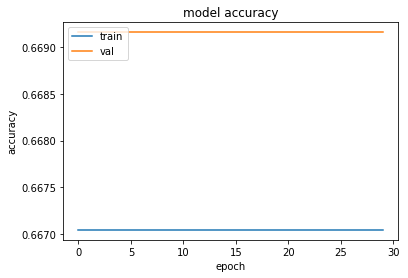

In [28]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
history.history

{'loss': [0.6554325453797529,
  0.6367650066422166,
  0.6364944405323557,
  0.6363460250561603,
  0.636419084188197,
  0.6373551624098074,
  0.6364008148957727,
  0.6367490252751983,
  0.636627532257123,
  0.6368039505758536,
  0.6364514990245805,
  0.6364658321780658,
  0.6362708361854268,
  0.6363847678073783,
  0.6363540659236551,
  0.6366052896342475,
  0.6363229124287094,
  0.6364405847220832,
  0.6363240557216973,
  0.6363364608546768,
  0.6363737496543913,
  0.6365529130014141,
  0.6363098956672439,
  0.6364031013478054,
  0.6363348675131352,
  0.6364162267817094,
  0.6363630661357208,
  0.6367757738752758,
  0.6363432322102093,
  0.6363325255640437],
 'accuracy': [0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.6670412,
  0.66704